# MCMC Demo

## Run MCMC

In [3]:
import yaml
from espei import run_espei
from pycalphad import Database

### xml file from DAT 

In [2]:
from pycalphad import Database

dbf = Database("ESPEI-Ocadiz_combined.dat")
dbf.to_file("ESPEI-Ocadiz_combined.xml")

In [4]:
dbf = Database("ESPEI-Ocadiz_combined.xml")
phases = list(dbf.phases.keys())
print(phases)

['F(S)', 'F2(G)', 'K(S)', 'KF_L1(LIQ)', 'KF_S1(S)', 'K_SOLID(S)', 'LI(S)', 'LIF_L1(LIQ)', 'LIF_S1(S)', 'LIQUID', 'LI_SOLID(S)', 'NA(S)', 'NAF_L1(LIQ)', 'NAF_S1(S)', 'NA_SOLID(S)', 'NI(S)', 'NIF2_L1(LIQ)', 'NIF2_S1(S)', 'NIF4LI2_S1(S)', 'NIK2F4_S1(S)', 'NIKF3_S1(S)', 'NINAF3_S1(S)', 'NI_SOLID_FCC(S)']


In [ ]:
#Plesae put experimental input (ESPEI-ZPF-*.json) into a folder (ex. input_data)

In [6]:
with open('ESPEI_demo.yaml') as fp:
    mcmc_settings = yaml.safe_load(fp)
dbf_mcmc, sampler = run_espei(mcmc_settings)

INFO:espei.espei_script - espei version       0.0.0
INFO:espei.espei_script - If you use ESPEI for work presented in a publication, we ask that you cite the following paper:
    B. Bocklund, R. Otis, A. Egorov, A. Obaied, I. Roslyakova, Z.-K. Liu, ESPEI for efficient thermodynamic database development, modification, and uncertainty quantification: application to Cu-Mg, MRS Commun. (2019) 1-10. doi:10.1557/mrc.2019.59.
INFO:espei.espei_script - Not using a parallel scheduler. ESPEI is running MCMC on a single core.
INFO:espei.error_functions.context - Fitting 2 degrees of freedom.
INFO:espei.optimizers.opt_mcmc - Initializing a zero prior for the parameters.
INFO:espei.optimizers.opt_mcmc - Initializing 16 chains with 8 chains per parameter.
INFO:espei.optimizers.opt_mcmc - Using a deterministic ensemble sampler.
INFO:espei.optimizers.opt_mcmc - Running MCMC for 10 iterations.
[                              ] (1 of 10)

[###                           ] (2 of 10)

[######                

## Convergence test

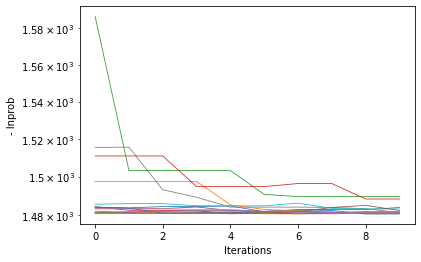

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from espei.analysis import truncate_arrays
trace = np.load('trace_demo.npy')
lnprob = np.load('lnprob_demo.npy')
trace, lnprob = truncate_arrays(trace, lnprob)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('- lnprob')
num_chains = lnprob.shape[0]
for i in range(num_chains):
    ax.plot(-lnprob[i,:], linewidth=0.8)
plt.show()

## Plot Phase Diagram

In [8]:
from pycalphad import Database, equilibrium, variables as v
from pycalphad.plot.eqplot import eqplot
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pycalphad.models.model_mqmqa import ModelMQMQA
from espei.plot import dataplot
from espei.datasets import load_datasets, recursive_glob
from pycalphad.plot.utils import phase_legend

In [9]:
"""
The eqplot module contains functions for general plotting of
the results of equilibrium calculations.
"""
from pycalphad.core.utils import unpack_condition
from pycalphad.plot.utils import phase_legend
import pycalphad.variables as v
from matplotlib import collections as mc
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

# TODO: support other state variables here or make isinstance elif == v.T or v.P
_plot_labels = {v.T: 'Temperature (K)', v.P: 'Pressure (Pa)'}


def _axis_label(ax_var):
    if isinstance(ax_var, v.MoleFraction):
        return 'X({})'.format(ax_var.species.name)
    elif isinstance(ax_var, v.StateVariable):
        return _plot_labels[ax_var]
    else:
        return ax_var

def _map_coord_to_variable(coord):
    """
    Map a coordinate to a StateVariable object.

    Parameters
    ----------
    coord : str
        Name of coordinate in equilibrium object.

    Returns
    -------
    pycalphad StateVariable
    """
    vals = {'T': v.T, 'P': v.P}
    if coord.startswith('X_'):
        return v.X(coord[2:])
    elif coord in vals:
        return vals[coord]
    else:
        return coord


def eqplot(eq, ax=None, x=None, y=None, z=None, tielines=True, tieline_color=(0, 1, 0, 1), tie_triangle_color=(1, 0, 0, 1), legend_generator=phase_legend, **kwargs):
    """
    Plot the result of an equilibrium calculation.

    The type of plot is controlled by the degrees of freedom in the equilibrium calculation.

    Parameters
    ----------
    eq : xarray.Dataset
        Result of equilibrium calculation.
    ax : matplotlib.Axes
        Default axes used if not specified.
    x : StateVariable, optional
    y : StateVariable, optional
    z : StateVariable, optional
    tielines : bool
        If True, will plot tielines
    tieline_color: color
        A valid matplotlib color, such as a named color string, hex RGB
        string, or a tuple of RGBA components to set the color of the two
        phase region tielines. The default is an RGBA tuple for green:
        (0, 1, 0, 1).
    tie_triangle_color: color
        A valid matplotlib color, such as a named color string, hex RGB
        string, or a tuple of RGBA components to set the color of the two
        phase region tielines. The default is an RGBA tuple for red:
        (1, 0, 0, 1).
    legend_generator : Callable
        A function that will be called with the list of phases and will
        return legend labels and colors for each phase. By default
        pycalphad.plot.utils.phase_legend is used
    kwargs : kwargs
        Passed to `matplotlib.pyplot.scatter`.

    Returns
    -------
    matplotlib AxesSubplot
    """
    conds = OrderedDict([(_map_coord_to_variable(key), unpack_condition(np.asarray(value)))
                         for key, value in sorted(eq.coords.items(), key=str)
                         if (key in ('T', 'P', 'N')) or (key.startswith('X_'))])
    indep_comps = sorted([key for key, value in conds.items() if isinstance(key, v.MoleFraction) and len(value) > 1], key=str)
    indep_pots = [key for key, value in conds.items() if (type(key) is v.StateVariable) and len(value) > 1]

    # determine what the type of plot will be
    if len(indep_comps) == 1 and len(indep_pots) == 1:
        projection = None
    elif len(indep_comps) == 2 and len(indep_pots) == 0:
        projection = 'triangular'
    else:
        projection = None
    #if z is not None:
    #    raise NotImplementedError('3D plotting is not yet implemented')
    if ax is None:
        fig, (ax) = plt.subplots(subplot_kw={'projection': projection})
    # Handle cases for different plot types
    if projection is None:
        x = indep_comps[0] if x is None else x
        y = indep_pots[0] if y is None else y
        # plot settings
        ax.set_xlim([np.min(conds[x]) - 1e-2, np.max(conds[x]) + 1e-2])
        ax.set_ylim([np.min(conds[y]), np.max(conds[y])])
    elif projection == 'triangular':
        x = indep_comps[0] if x is None else x
        y = indep_comps[1] if y is None else y
        # Here we adjust the x coordinate of the ylabel.
        # We make it reasonably comparable to the position of the xlabel from the xaxis
        # As the figure size gets very large, the label approaches ~0.55 on the yaxis
        # 0.55*cos(60 deg)=0.275, so that is the xcoord we are approaching.
        ax.yaxis.label.set_va('baseline')
        fig_x_size = ax.figure.get_size_inches()[0]
        y_label_offset = 1 / fig_x_size
        ax.yaxis.set_label_coords(x=(0.275 - y_label_offset), y=0.5)

    phases = map(str, sorted(set(np.array(eq.Phase.values.ravel(), dtype='U')) - {''}, key=str))
    comps = map(str, sorted(np.array(eq.coords['component'].values, dtype='U'), key=str))
    eq['component'] = np.array(eq['component'], dtype='U')
    eq['Phase'].values = np.array(eq['Phase'].values, dtype='U')

    # Select all two- and three-phase regions
    three_phase_idx = np.nonzero(np.sum(eq.Phase.values != '', axis=-1, dtype=np.int_) == 3)
    two_phase_idx = np.nonzero(np.sum(eq.Phase.values != '', axis=-1, dtype=np.int_) == 2)

    legend_handles, colorlist = legend_generator(phases)

    # For both two and three phase, cast the tuple of indices to an array and flatten
    # If we found two phase regions:
    if two_phase_idx[0].size > 0:
        found_two_phase = eq.Phase.values[two_phase_idx][..., :2]
        # get tieline endpoint compositions
        two_phase_x = eq.X.sel(component=x.species.name).values[two_phase_idx][..., :2]
        two_phase_z = eq.X.sel(component=z.species.name).values[two_phase_idx][..., :2]
        #print('two_phase_x:', two_phase_x[..., 0])
        # handle special case for potential
        if isinstance(y, v.MoleFraction):
            two_phase_y = eq.X.sel(component=y.species.name).values[two_phase_idx][..., :2]
        else:
            # it's a StateVariable. This must be True
            two_phase_y = np.take(eq[str(y)].values, two_phase_idx[eq.Phase.dims.index(str(y))])

            # because the above gave us a shape of (n,) instead of (n,2) we are going to create it ourselves
            two_phase_y = np.array([two_phase_y, two_phase_y]).swapaxes(0, 1)

        # plot two phase points
        two_phase_plotcolors = np.array(list(map(lambda x: [colorlist[x[0]], colorlist[x[1]]], found_two_phase)), dtype='U')
        ax.scatter(two_phase_x[..., 0]/(two_phase_x[..., 0]+two_phase_z[..., 0]), two_phase_y[..., 0], s=3, c=two_phase_plotcolors[:, 0], edgecolors='None', zorder=2, **kwargs)
        ax.scatter(two_phase_x[..., 1]/(two_phase_x[..., 1]+two_phase_z[..., 1]), two_phase_y[..., 1], s=3, c=two_phase_plotcolors[:, 1], edgecolors='None', zorder=2, **kwargs)
        result1=[two_phase_x[..., 0]/(two_phase_x[..., 0]+two_phase_z[..., 0]), two_phase_y[..., 0], two_phase_x[..., 1]/(two_phase_x[..., 1]+two_phase_z[..., 1]), two_phase_y[..., 1]]
        #np.savetxt('tie-lines.txt', result1)

        if tielines:
            # construct and plot tielines
            two_phase_tielines = np.array([np.concatenate((two_phase_x[..., 0][..., np.newaxis]/(two_phase_x[..., 0][..., np.newaxis]+two_phase_z[..., 0][..., np.newaxis]), two_phase_y[..., 0][..., np.newaxis]), axis=-1),
                                           np.concatenate((two_phase_x[..., 1][..., np.newaxis]/(two_phase_x[..., 1][..., np.newaxis]+two_phase_z[..., 1][..., np.newaxis]), two_phase_y[..., 1][..., np.newaxis]), axis=-1)])
            two_phase_tielines = np.rollaxis(two_phase_tielines, 1)
            lc = mc.LineCollection(two_phase_tielines, zorder=1, colors=tieline_color, linewidths=[0.5, 0.5])
            ax.add_collection(lc)

    # position the phase legend and configure plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True)
    plot_title = '-'.join([component.title() for component in sorted(comps) if component != 'VA'])
    ax.set_title(plot_title, fontsize=20)
    ax.set_xlabel(_axis_label(x), labelpad=15, fontsize=20)
    ax.set_ylabel(_axis_label(y), fontsize=20)

    return ax


In [10]:
T_KALINNIKOV=[1496,1358,1384,1349,1323,1270,1238,1206,1146,1084,1091,1345,1360,1348,1193,1196,
             1196,1193,1202,1067,1087,1064,1064,1065,1066,1061,1060]
X_NI_KALINNIKOV=[0.286114263399503,0.239666072059557,0.2,0.183979110178573,
                0.166526197506644,0.130666964453800,0.111068920071575,
                0.106198764025641,0.0703995697206828,0.0482109991911150
                ,0.0244068846655921,0.284988177674562,0.250081089762902,0.250081089762902,
                0.182502756276773,0.165698835252876,0.129011525335829,0.109674827463173,
                 0.0897018108321103,0.0230137293428380,0.0229946928578328,0.0418074023622608,
                0.0468074995241425,0.0686759001264073,0.0898154135237013,0.110021498961456,
                0.129347084249032]
X_NIF2_KALINNIKOV=[]
for i in X_NI_KALINNIKOV:
    xnif2=i/((1-3*i)/2+i)
    X_NIF2_KALINNIKOV.append(xnif2)
T_WAGNER=[1461,1431,1376,1386,1403,1405,1403,1390,1362,1330,1320,1295,1256,1231,1225,1211,1206,1196,
           1171,1122,1103,1076,1068,1069,1067,1069,1068,1067,1067,1062,1062,1199,1199,1202,1197,1202,
         1203,1199,1189,1347,1353,1352,1353,1352]
X_NI_WAGNER=[0.272789000512432,0.263953812006467,0.241081738730110
             ,0.225292819752777,0.209600071697494,0.2,0.190058479393621,
                0.179914437168285,0.159706174340340,0.147885860851683
                ,0.139373729009910,0.132063152513647,0.122273227237068
                ,0.118479653494450,0.115621014326388,0.106932762277802,0.102525826498741,
                0.0980721071219325,0.0849563551678476,0.0629386359354494
                ,0.0241252643974626,0.0612205734572148,0.0834714719020692,0.0973099234527300,
            0.101504428809786,0.105414808094177,0.114092121823492,0.116711018395093,
            0.121431442367838,0.130496418693214,0.138244724546411,0.113988412869821,0.116844230617027,
            0.121325595235053,0.130392744659702,0.137913211581586,0.147302344537439,0.158004771260267,
            0.188557776937020,0.208381683236155,0.223703881522668,0.240032738006506,0.262532138623549,
            0.272002649578389]
X_NIF2_WAGNER=[]
for i in X_NI_WAGNER:
    xnif2=i/((1-3*i)/2+i)
    X_NIF2_WAGNER.append(xnif2)
T_OCADIZ_FLORES=[1398,1320]
X_NI_OCADIZ_FLORES=[0.2,0.142078328059048]
X_NIF2_OCADIZ_FLORES=[]
for i in X_NI_OCADIZ_FLORES:
    xnif2=i/((1-3*i)/2+i)
    X_NIF2_OCADIZ_FLORES.append(xnif2)

['F(S)', 'F2(G)', 'K(S)', 'KF_L1(LIQ)', 'KF_S1(S)', 'K_SOLID(S)', 'LI(S)', 'LIF_L1(LIQ)', 'LIF_S1(S)', 'LIQUID', 'LI_SOLID(S)', 'NA(S)', 'NAF_L1(LIQ)', 'NAF_S1(S)', 'NA_SOLID(S)', 'NI(S)', 'NIF2_L1(LIQ)', 'NIF2_S1(S)', 'NIF4LI2_S1(S)', 'NIK2F4_S1(S)', 'NIKF3_S1(S)', 'NINAF3_S1(S)', 'NI_SOLID_FCC(S)']


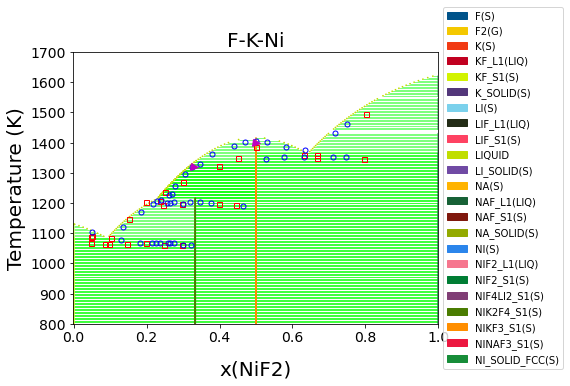

In [12]:
fig= plt.figure(figsize=(25,5))
ax = fig.add_subplot()
dbf = Database('MCMC_demo.xml')
comps = ['NI', 'K', 'F']
phases = list(dbf.phases.keys())
#phases = ['LIQUID', 'NIF2_S1(S)',  'KF_S1(S)', 'NIK2F4_S1(S)', 'NIKF3_S1(S)']
print(phases)
datasets = load_datasets(recursive_glob('input_data', '*.json'))
def fixed_phase_legend(phases):
    legend_handles, colorlist = phase_legend(phases)
    def _dummy_phase_legend(_):
        return legend_handles, colorlist
    return _dummy_phase_legend


conds = {v.N: 1, v.P: 101325, v.T: (800,1800,5), v.X('NI'): 0.000249937515621095, v.X('K'):0.499625093726568}
eq_1 = equilibrium(dbf, comps, phases, conds, verbose=False)


conds = {v.N: 1, v.P: 101325, v.T: (800,1800,5), v.X('NI'):0.137931034482759, v.X('K'):0.293103448275862}
eq_2 = equilibrium(dbf, comps, phases, conds, verbose=False)

conds = {v.N: 1, v.P: 101325, v.T: (800,1800,5), v.X('NI'):0.145299145299145, v.X('K'):0.282051282051282}
eq_3 = equilibrium(dbf, comps, phases, conds, verbose=False)

conds = {v.N: 1, v.P: 101325, v.T: (800,1800,5), v.X('NI'):0.196787148594377, v.X('K'):0.204819277108434}
eq_4 = equilibrium(dbf, comps, phases, conds, verbose=False)

conds = {v.N: 1, v.P: 101325, v.T: (800,1800,5), v.X('NI'):0.200015999680006, v.X('K'):0.199976000479990}
eq_5 = equilibrium(dbf, comps, phases, conds, verbose=False)

conds = {v.N: 1, v.P: 101325, v.T: (800,1800,5), v.X('K'):0.00334448160535117, v.X('NI'): 0.331103678929766}
eq_6 = equilibrium(dbf, comps, phases, conds, verbose=False)

phase_leg_func = fixed_phase_legend(phases)

eqplot(eq_1, x=v.X('NI'), y=v.T, z=v.X('K'),legend_generator=phase_leg_func, ax=ax)
eqplot(eq_2, x=v.X('NI'), y=v.T, z=v.X('K'),legend_generator=phase_leg_func, ax=ax)
eqplot(eq_3, x=v.X('NI'), y=v.T, z=v.X('K'),legend_generator=phase_leg_func, ax=ax)
eqplot(eq_4, x=v.X('NI'), y=v.T, z=v.X('K'),legend_generator=phase_leg_func, ax=ax)
eqplot(eq_5, x=v.X('NI'), y=v.T, z=v.X('K'),legend_generator=phase_leg_func, ax=ax)
eqplot(eq_6, x=v.X('NI'), y=v.T, z=v.X('K'),legend_generator=phase_leg_func, ax=ax)

ax.plot(X_NIF2_KALINNIKOV,
        T_KALINNIKOV, 'rs',ms=5,markerfacecolor='none',label='KALINNIKOV')
ax.plot(X_NIF2_WAGNER,
        T_WAGNER, 'bo',ms=5,markerfacecolor='none',label='WAGNER')
ax.plot(X_NIF2_OCADIZ_FLORES,
        T_OCADIZ_FLORES, 'm>',ms=7,label='OCADIZ_FLORES')

ax.set_xlim(-0.0025, 1)
ax.set_ylim(800, 1700)
ax.set_xlabel('x(NiF2)')
plt.grid(False)
plt.show()